In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib
import multiprocessing as mp

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
with open('../inputs/gb1.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[1]
y = t[2]
wt = t[3]

In [3]:
helpers = importlib.reload(helpers)
np.random.seed(120120)
_ = torch.manual_seed(43298)

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

n = 300
train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True))

y_train = y[train_inds]
y_true = y
A_train = A[train_inds]
A_test = A

inds = sorted(set(itertools.chain(train_inds)))


dic, means, mo = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2, sn=0.01, return_model=True)

Iteration 3000 of 3000	NLML: 128.3087	sn: 0.322554	

In [4]:
mo.kernel.ell

Parameter containing:
tensor([ 19.0573])

In [5]:
aas = 'ARNDCQEGHILKMFPSTWYV'
ground = [(aa, i) for aa in aas for i in range(4)]

In [6]:
seen_seqs = [helpers.decode_X(X[i]) for i in inds]
for s in seen_seqs:
    dic[s] = 0.0

In [7]:
seed = helpers.get_seed(dic)
seed

[('A', 0), ('G', 1), ('R', 2), ('N', 3)]

In [8]:
with open('../outputs/20180828_modmod_not_mono.pkl', 'rb') as f:
    X_list, obj_list = pickle.load(f)

In [50]:
objectives = importlib.reload(objectives)
opt = importlib.reload(opt)
helpers = importlib.reload(helpers)


_, ob, X_list2, obj_list = opt.greedy(ground, seed, objectives.objective, 1, obj_args=(4, dic, 100), return_all=True)

In [10]:
tau = max((y_train - np.mean(y_train)) / np.std(y_train))
tau

2.7241459632473894

In [64]:
%%time 
objectives = importlib.reload(objectives)
tau = max((y_train - np.mean(y_train)) / np.std(y_train))
tau = 2.7246
observed = seen_seqs
X_all = A
n = 100
L = 4
its = 100000
np.random.seed(129)
_ = torch.manual_seed(450)

appro = []

for lib in X_list2:
    ob2 = objectives.objective(lib, L, dic, n)
    appro.append(ob2.item())
    
results = [objectives.sample_obj(lib, mo, tau, seq_to_x, X_all, observed=observed, its=its,
                                      n=n, return_all=True)
           for lib in X_list2]
samples = [result[1].detach().numpy() for result in results]

CPU times: user 7min 24s, sys: 3.61 s, total: 7min 28s
Wall time: 7min 33s


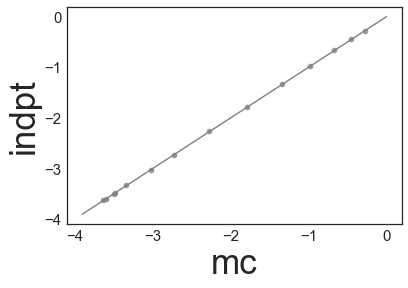

In [70]:
for ap, sa in zip(appro, samples):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(-sa.mean(), ap, xerr=2*SE, fmt='o', alpha=0.8, color='grey')
_ = plt.plot([-3.9, 0], [-3.9, 0], color='grey')
_ = plt.xlabel('mc')
_ = plt.ylabel('indpt')

In [72]:
[helpers.get_N(lib, L) for lib in X_list2]

[1, 2, 4, 8, 12, 24, 36, 48, 72, 90, 120, 90, 108, 126]

In [91]:
np.random.seed(45)
X0 = np.random.choice(80, 20, replace=False)
X0 = sorted(set(([ground[i] for i in X0] + X_list2[-1])))
_, ob, X_list3, obj_list2 = opt.greedy(ground, X0, objectives.objective, 1, 
                                       obj_args=(4, dic, 100), return_all=True)

In [93]:
%%time 
np.random.seed(364)
results = [objectives.sample_obj(lib, mo, tau, seq_to_x, X_all, observed=observed, its=its,
                                      n=n, return_all=True)
           for lib in X_list3]
samples2 = [result[1].detach().numpy() for result in results]

CPU times: user 20min 7s, sys: 10.2 s, total: 20min 17s
Wall time: 20min 26s


In [92]:
ns = [helpers.get_N(lib, L) for lib in X_list3]
for nn, ob in zip(ns, obj_list2):
    print(nn, ob.item())

2640 -0.5255842208862305
2112 -0.6292963027954102
1584 -0.7883062362670898
1320 -0.9377927780151367
1056 -1.1568775177001953
792 -1.4846296310424805
528 -1.8643159866333008
264 -2.1403908729553223
231 -2.302520751953125
198 -2.483508586883545
165 -2.692676305770874
132 -2.93994140625
99 -3.0940463542938232
198 -3.192519187927246
180 -3.3062219619750977
162 -3.4196243286132812
144 -3.515052318572998
126 -3.6209189891815186


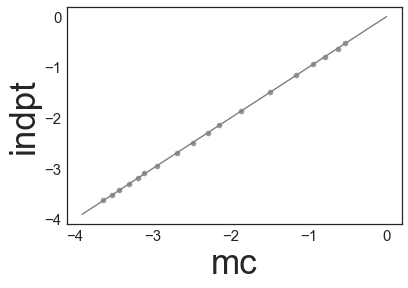

In [94]:
for ap, sa in zip(obj_list2, samples2):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(-sa.mean(), ap, xerr=2*SE, fmt='o', alpha=0.8, color='grey')
_ = plt.plot([-3.9, 0], [-3.9, 0], color='grey')
_ = plt.xlabel('mc')
_ = plt.ylabel('indpt')

In [96]:
vals = np.array([dic[k] for k in dic.keys()])

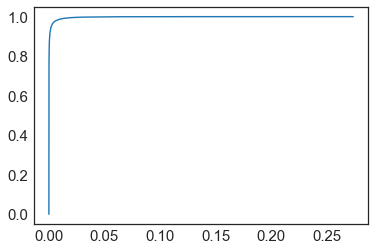

In [97]:
_ = plt.plot(np.sort(vals), np.linspace(0, 1, len(vals)))

In [100]:
np.sort(vals)[-10:]

array([tensor(0.1220), tensor(0.1275), tensor(0.1295), tensor(0.1363),
       tensor(0.1385), tensor(0.1458), tensor(0.1536), tensor(0.1565),
       tensor(0.1768), tensor(0.2739)], dtype=object)

In [101]:
seed

[('A', 0), ('G', 1), ('R', 2), ('N', 3)]

In [108]:
fY = objectives.objective([g for g in ground if g != ['N', 3]], L, dic, n)

In [109]:
objectives.objective(ground, L, dic, n) - fY

tensor(0.)